# Model Performance
We can assess the models performance by comparing the AI's predictions to the manual corrections.

## Prerequisites
Install python packages

In [1]:
%%capture
%pip install pandas pydicom pydicom-seg scikit-image scikit-learn seaborn segmentationmetrics requests

Import required python packages

In [2]:
import warnings

warnings.filterwarnings("ignore")

import io
import zipfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
import pydicom_seg
import requests
import scipy.stats as stats
import seaborn as sns
import segmentationmetrics as sm
import SimpleITK as sitk
import skimage.measure
from segmentationmetrics.surface_distance import compute_surface_dice_at_tolerance

from kits_metrics import compute_metrics_for_case

sns.set_theme(style="whitegrid")
%matplotlib inline

In [3]:
plt_colors = {
    "ne1": "#5eceb0",
    "rad1": "#9e70e1",
    "tp": "k",
    "fp": "b",
    "fn": "r",
}

revewer_cmap = sns.color_palette([plt_colors["ne1"], plt_colors["rad1"]])
vol_cmap = sns.color_palette([plt_colors["fp"], plt_colors["fn"]])
bubble_cmap = sns.color_palette([plt_colors["tp"], plt_colors["fp"], plt_colors["fn"]])

To compare model performance against the manual corrections, we need to download the dicom-seg files of the ai predictions and the manual corrections from zenodo.

In [4]:
qa_dir = Path("qa-results")

In [5]:
def download_inference(
    extract_dir="qa-results", record="13244892", filename="kidney-ct.zip"
):
    url = f"https://zenodo.org/record/{record}/files/{filename}"
    # download the zip file and extract it
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(extract_dir)


if not qa_dir.exists() or not (qa_dir / "ai-segmentations-dcm").exists():
    download_inference(qa_dir)

## Data Description
The dataset was reviewed by two reviewers, a radiologist and a 'non-expert'. The non-expert was a medical student with some familiarity with radiology images. For this project, the non-expert scored every ai prediction while the radiologist only scored the validation set.

Alone with the segmentation files, we also have a `qa-resulst.csv` file that gives more information on the quality assessment feedback from the manual reviewers.

| column                      | description                                                                                      |
| --------------------------- | ------------------------------------------------------------------------------------------------ |
| Reviewer                    | Either `rad1` or `ne1` for Radiologist 1 and Non-expert 1 respectively                           |
| Validataion                 | if this scan was in the validation set                                                           |
| Collection                  | IDC collection name                                                                              |
| PatientID                   | PatientID from dicom                                                                             |
| StudyDate                   | StudyDate from dicom                                                                             |
| StudyDate_suffix            | incrementing value to differentiate different scans from the same StudyDate                      |
| StudyInstanceUID            | StudyInstanceUID from dicom                                                                      |
| SeriesInstanceUID           | SeriesInstanceUID from dicom                                                                     |
| FineTune | if this scan was used for training or test in the stage 2 model |
| AISegmentation              | filename of ai segmentation                                                                      |
| LikertScore                 | Reviewers opinion of how accurate the AI prediction was, see table below fr                      |
| CommentsAboutAISegmentation | comments from the reviewer about the ai segmentation, usually how the AI underperformed          |
| CommentsAboutScan           | comments from the reviewer about the scan, could be about unusual anatomy or scan artifacts.     |
| KidneyVisibility | The esimated percent of the kidneys that were in the scan field of view |
| ContrastPhase | The contrast phase of the scan as noted by the reviewer |
| KidneyCystTumorAssessment | yes/no if the scan is sufficient quality to identify cysts and tumors |
| CorrectedSegmentation       | file name of the manually corrected segmentation, this file is in `qa-segmentations-dcm`` folder |

The Likert scale used for scoring was:

| Score | Meaning |
| --- | --- |
| 5 | Strongly Agree - Use-as-is (i.e., clinically acceptable, and could be used for treatment without change) |
| 4 | Agree - Minor edits that are not necessary. Stylistic differences, but not clinically important. The current segmentation is acceptable |
| 3 | Neither agree nor disagree - Minor edits that are necessary. Minor edits are those that the review judges can be made in less time than starting from scratch or are expected to have minimal effect on treatment outcome |
| 2 | Disagree - Major edits. This category indicates that the necessary edit is required to ensure correctness, and sufficiently significant that user would prefer to start from the scratch |
| 1 | Strongly disagree - Unusable. This category indicates that the quality of the automatic annotations is so bad that they are unusable.|

The TCGA-KIRC dataset is a collection of scans performed during clinical care. The field of view and contrast phase of the scans can vary. The reviewers were asked to give feedback on the scan to categorize the model performance.

Since the field of view of the scans varied, the reviewers were asked "How much of the kidneys, would you estimate, are visible in the scan?" with the options:
* 100%
* 60 - 99%
* 30 - 60%
* 10 - 30%
* 1 - 10%
* 0%

These values are in the `KidneyVisibility` column of the `qa-results.csv` file.

The reviewers were also asked "Which Contrast Phase does the scan show?". The options were:
* No contrast in scan
* Early arterial phase
* Corticomedullary phase / Late arterial phase
* Nephrogenic phase / Renal parenchymal phase
* Excretory phase
The AI model was only trained on data from corticomedullary and nephrogenic phases. Since the contrast phase was not know before hand, the reviewers feedback would show how much of the models performance was attributable to scan phase.

The reviewers were asked yes/no question "Is it possible to assess this scan for kidney cysts and kidney tumors?" this result was recorded in the `KidneyCystTumorAssessment` column of the `qa-results.csv` file. The object was to determine if a human could identify cysts & tumors in the scan. This was a quick filter to decide if the AI model was likely to fail.

Because of the heterogeneity of the collection, a larger validation set was selected (25%)


In [6]:
df = pd.read_csv(
    qa_dir / "qa-results.csv",
    dtype={
        "PatientID": str,
        "StudyDate": str,
        "StudyDate_suffix": str,
        "LikertScore": int,
    },
)
df["CorrectedSegmentation"].fillna("", inplace=True)
df.replace({"rad1": "Radiologist", "ne1": "Non-expert"}, inplace=True)
# get validation subset
val_df = df[df["Validation"]]
validation_size = len(val_df["SeriesInstanceUID"].unique())
total_size = len(df["SeriesInstanceUID"].unique())
print(
    f"{validation_size/total_size*100:.2f}% of scans were validated ({validation_size}/{total_size})"
)

# get validation done by different reviewers
rad_df = val_df.loc[val_df["Reviewer"] == "Radiologist"]
ne_df = val_df.loc[
    (val_df["Reviewer"] == "Non-expert")
    & (val_df["AISegmentation"]).isin(rad_df["AISegmentation"])
]

rad_df = rad_df.sort_values(by=["AISegmentation"])
ne_df = ne_df.sort_values(by=["AISegmentation"])

assert len(rad_df) == len(ne_df)
assert len(rad_df) == len(rad_df["AISegmentation"].unique())

print(f"{len(rad_df)} scans were reviewed by radiologist and non-expert")

25.00% of scans were validated (39/156)
39 scans were reviewed by radiologist and non-expert


We caluclate the Kendall-𝜏 score between the two reviewers. Kendall-𝜏 is a measure of correlation between raters or ordinal data. This tells us how much we can trust the scores given by the non-expert reviewer for the portion of the dataset the Radiologist did not review.
For this dataset, there is a very moderate positive correlation between the two reviewers. 

In [7]:
tau, p_value = stats.kendalltau(rad_df.LikertScore.values, ne_df.LikertScore.values)
print(f"Kendall's tau: {tau:.2f}, p-value: {p_value:.2f}")

# Calculate percentage agreement

total_cases = len(rad_df.LikertScore)
matching_cases = np.sum(rad_df.LikertScore.values == ne_df.LikertScore.values)
percentage_agreement = (matching_cases / total_cases) * 100

print(f"Percentage Agreement: {percentage_agreement:.2f}%")

Kendall's tau: 0.58, p-value: 0.00
Percentage Agreement: 51.28%


The radiologist and non-expert reviewer had a moderate amount of agreement. From the graph below you can see that the non-expert reviewer was more likely to give a higher score than the radiologist. The radiologist did not give any scores of 5.

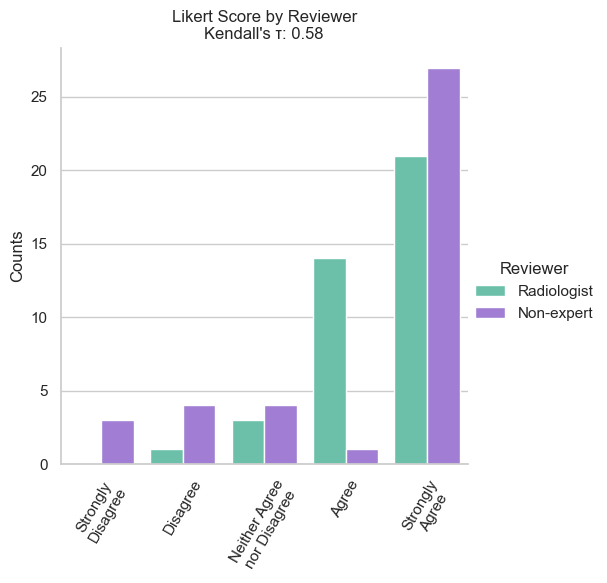

In [8]:
g = sns.catplot(
    data=val_df,
    kind="count",
    x="LikertScore",
    order=[1, 2, 3, 4, 5],
    hue="Reviewer",
    hue_order=["Radiologist", "Non-expert"],
    palette=revewer_cmap,
)
g.set_axis_labels("", "Counts")
g.set(title=f"Likert Score by Reviewer\nKendall's \u03c4: {tau:.2f}")
g.set_xticklabels(
    labels=[
        "Strongly\nDisagree",
        "Disagree",
        "Neither Agree\nnor Disagree",
        "Agree",
        "Strongly\nAgree",
    ],
    rotation=60,
)

Text(0.5, 1.0, 'Likert Score Distribution for Radiologist')

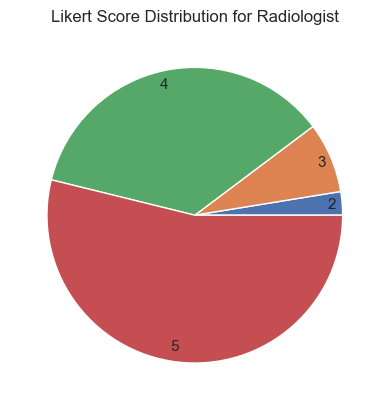

In [9]:
pie_df = (
    rad_df["LikertScore"].value_counts().reset_index().sort_values(by="LikertScore")
)
plt.pie(
    pie_df["count"].values,
    labels=pie_df["LikertScore"].values,
    labeldistance=0.9,
)
plt.title("Likert Score Distribution for Radiologist")

The reviewers also corrected the AI predictions for the validation set when their Likert rating was not 5. We can assess the reviewers agreement with the AI from segmentation metrics of Dice Similarity Coefficient (DSC), 95% Hausdorff distance, and Normalized Mean Surface Distance (NSD). Metrics are calculated the similar to those used in the KiTs23 challenge. The KiTS challenged named labels slightly differently than our model. KiTS uses the terms 'kidney', 'tumor', 'cysts' as labels, and in their scoring they use the term 'mass' to mean 'tumor+cyst'. We have used DICOM standard terms of 'kidney', 'mass', 'cyst' as the label names, but they are three labels as KiTS23 ('kidney', 'tumor', 'cyst'). I have used the more read able names of 'kidney', 'tumor', and 'cyst' in this notebook to avoid the confusing of 'mass' meaning 'tumor+cyst'.

* DSC measures volume similarity between two segmentations.
* NSD measures the average distance between the surfaces. It includes an acceptable tolerance that is dependant on the task. For KiTS23, the tolerances (mm) were:
  * kidney_tumor_cyst: 1.0330772532390826
  * tumor_cyst: 1.1328796488598762
  * tumor: 1.1498198361434828

In [10]:
def load_dcm_seg(seg_path: Path, label=1):
    dcm = pydicom.dcmread(str(seg_path))
    reader = pydicom_seg.SegmentReader()
    result = reader.read(dcm)
    if label in result.available_segments:
        image = result.segment_image(label)
        image = sitk.Cast(image, sitk.sitkUInt8)
    else:
        # return empty image
        image = result.segment_image(list(result.available_segments)[0])
        image = sitk.Cast(image, sitk.sitkUInt8)
        image = image * 0  # set to 0
    return image


def load_kits_dcm_seg(seg_path: Path):
    dcm = pydicom.dcmread(str(seg_path))
    reader = pydicom_seg.MultiClassReader()
    result = reader.read(dcm)
    image = sitk.Cast(result.image, sitk.sitkUInt8)
    return image


def load_nii_seg(seg_path: Path, label=1):
    img = sitk.ReadImage(str(seg_path))
    img = sitk.Cast(img == label, sitk.sitkUInt8)
    return img


def load_seg(seg_path: Path, label=1):
    if seg_path.suffix == ".dcm":
        return load_dcm_seg(seg_path, label)
    else:
        return load_nii_seg(seg_path, label)


def resize_label(img: sitk.Image, ref_img: sitk.Image, interp=sitk.sitkNearestNeighbor):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(ref_img)
    resampler.SetInterpolator(interp)
    resampler.SetDefaultPixelValue(0)
    resampled_img = resampler.Execute(img)
    return resampled_img


def calc_metrics_for_label(ai_seg_file, qa_seg_file, label_value=1, label_suffix=""):
    ai_img = load_seg(ai_seg_file, label_value)
    qa_img = load_seg(qa_seg_file, label_value)
    qa_img = resize_label(qa_img, ai_img)  # match the size of the ai_img
    ai_arr = sitk.GetArrayFromImage(ai_img)
    qa_arr = sitk.GetArrayFromImage(qa_img)
    spacing = ai_img.GetSpacing()[::-1]  # numpy is reversed dimensions from sitk

    qa_img = resize_label(qa_img, ai_img)  # match the size of the ai_img
    m = sm.SegmentationMetrics(ai_arr, qa_arr, spacing)

    metrics = {
        "dice": m.dice,
        "hausdorff_distance_95": m.hausdorff_distance,
        "mean_surface_distance": m.mean_surface_distance,
        "mean_surface_distance_tol_7": compute_surface_dice_at_tolerance(
            m._surface_dist, 7
        ),  # from medical segmentation decathlon
    }
    if label_suffix:
        metrics = {f"{k}_{label_suffix}": v for k, v in metrics.items()}
    return metrics


def get_false_discovery(
    img_file_pred: str, img_file_gt: str, label_value: int = 1, prefix=""
):
    """Get the false discovery rate for two images, predicted (image_file_pred) and ground truth (image_file_gt)."""
    img_pred = load_seg(img_file_pred, label_value)
    img_gt = load_seg(img_file_gt, label_value)
    img_gt = resize_label(img_gt, img_pred)  # match the size of the qa_img

    vox_ml = np.prod(img_pred.GetSpacing()) / 1000

    pd_arr = sitk.GetArrayFromImage(img_pred)
    gt_arr = sitk.GetArrayFromImage(img_gt)

    pd_cc = skimage.measure.label(pd_arr)
    gt_cc = skimage.measure.label(gt_arr)
    true_pd_cc = pd_cc.copy()
    true_pd_cc[gt_cc == 0] = 0
    overlap_gt_cc = gt_cc.copy()  # gt labels that overlap with predicted
    overlap_gt_cc[pd_cc == 0] = 0

    pd_labels = np.dstack(np.unique(pd_cc, return_counts=True))[0, 1:]
    gt_labels = np.dstack(np.unique(gt_cc, return_counts=True))[0, 1:]
    true_pd_labels = np.dstack(np.unique(true_pd_cc, return_counts=True))[0, 1:]
    overlap_gt_labels = np.dstack(np.unique(overlap_gt_cc, return_counts=True))[0, 1:]

    true_vol_overlap_ml = true_pd_labels[..., 1] * vox_ml

    # get false positives
    false_pos_vols_ml = []
    for pd_label, pd_size in pd_labels:
        if pd_label not in true_pd_labels[..., 0]:
            false_pos_vols_ml.append(pd_size * vox_ml)

    # get false negatives
    false_neg_vols_ml = []
    for gt_label, gt_size in gt_labels:
        if gt_label not in overlap_gt_labels[..., 0]:
            false_neg_vols_ml.append(gt_size * vox_ml)

    return {
        f"{prefix}-true_vol_overlap_ml": true_vol_overlap_ml,
        f"{prefix}-false_pos_vols_ml": false_pos_vols_ml,
        f"{prefix}-false_neg_vols_ml": false_neg_vols_ml,
        f"{prefix}-true_vol_overlap_ml_total": sum(true_vol_overlap_ml),
        f"{prefix}-false_pos_vol_ml_total": sum(false_pos_vols_ml),
        f"{prefix}-false_neg_vol_ml_total": sum(false_neg_vols_ml),
        f"{prefix}-true_vol_overlap_cnt": len(true_vol_overlap_ml),
        f"{prefix}-false_pos_cnt": len(false_pos_vols_ml),
        f"{prefix}-false_neg_cnt": len(false_neg_vols_ml),
    }


def add_metrics_to_df(df):
    for i, row in df.iterrows():
        ai_seg_file = qa_dir / "ai-segmentations-dcm" / row["AISegmentation"]
        if row["LikertScore"] < 5 and row["CorrectedSegmentation"] != "":
            qa_seg_file = qa_dir / "qa-segmentations-dcm" / row["CorrectedSegmentation"]
        else:
            qa_seg_file = ai_seg_file

        assert ai_seg_file.exists()
        assert qa_seg_file.exists()

        ai_img = load_kits_dcm_seg(ai_seg_file)
        qa_img = load_kits_dcm_seg(qa_seg_file)
        qa_img = resize_label(qa_img, ai_img)  # match the size of the ai_img
        kits_vals = compute_metrics_for_case(ai_img, qa_img)
        metrics = {}
        names = ["kidney_tumor_cyst", "tumor_cyst", "tumor"]
        for name, vals in zip(names, kits_vals):
            metrics[name + "-DSC"] = vals[0]
            metrics[name + "-NSD"] = vals[1]

        tumor_detection_metrics = get_false_discovery(
            ai_seg_file, qa_seg_file, label_value=2, prefix="tumor"
        )
        cysts_detection_metrics = get_false_discovery(
            ai_seg_file, qa_seg_file, label_value=3, prefix="cyst"
        )
        # ignore array values
        for x in ("true_vol_overlap_ml", "false_neg_vols_ml", "false_pos_vols_ml"):
            tumor_detection_metrics.pop(f"tumor-{x}")
            cysts_detection_metrics.pop(f"cyst-{x}")

        metrics.update(tumor_detection_metrics)
        metrics.update(cysts_detection_metrics)

        for k, v in metrics.items():
            df.loc[i, k] = v

In [11]:
add_metrics_to_df(rad_df)
add_metrics_to_df(ne_df)
xdf = pd.concat([rad_df, ne_df])

The DSC between the reviewers is similar, with only one scan ranked lower than 0.95.

The NSD is also high for both reviewers, but the non-expert reviewer has a higher NSD than the radiologist.

In [12]:
a = xdf[["Reviewer", "kidney_tumor_cyst-DSC", "kidney_tumor_cyst-NSD", "LikertScore"]]
a.rename(
    columns={"kidney_tumor_cyst-DSC": "DSC", "kidney_tumor_cyst-NSD": "NSD"},
    inplace=True,
)
a["Label"] = "kidney,tumor,cyst"
b = xdf[["Reviewer", "tumor_cyst-DSC", "tumor_cyst-NSD"]]
b.rename(columns={"tumor_cyst-DSC": "DSC", "tumor_cyst-NSD": "NSD"}, inplace=True)
b["Label"] = "tumor,cyst"
c = xdf[["Reviewer", "tumor-DSC", "tumor-NSD"]]
c.rename(columns={"tumor-DSC": "DSC", "tumor-NSD": "NSD"}, inplace=True)
c["Label"] = "tumor"

dsc_df = pd.concat([a, b, c], ignore_index=True)

# get mean for each label by reviewer
dsc_df.groupby(["Reviewer", "Label"]).agg(
    {"DSC": ["mean", "std"], "NSD": ["mean", "std"]}
).round(2)

DSC         NSD      
                               mean   std  mean   std
Reviewer    Label                                    
Non-expert  kidney,tumor,cyst  0.99  0.06  0.98  0.09
            tumor              0.96  0.19  0.95  0.20
            tumor,cyst         0.96  0.19  0.95  0.20
Radiologist kidney,tumor,cyst  0.93  0.22  0.91  0.23
            tumor              0.88  0.32  0.87  0.32
            tumor,cyst         0.88  0.32  0.87  0.32

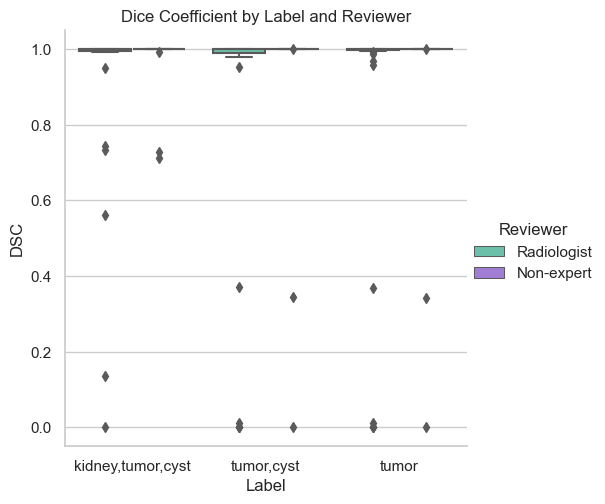

In [13]:
g = sns.catplot(
    data=dsc_df, x="Label", y="DSC", hue="Reviewer", kind="box", palette=revewer_cmap
)
g.set(title="Dice Coefficient by Label and Reviewer")

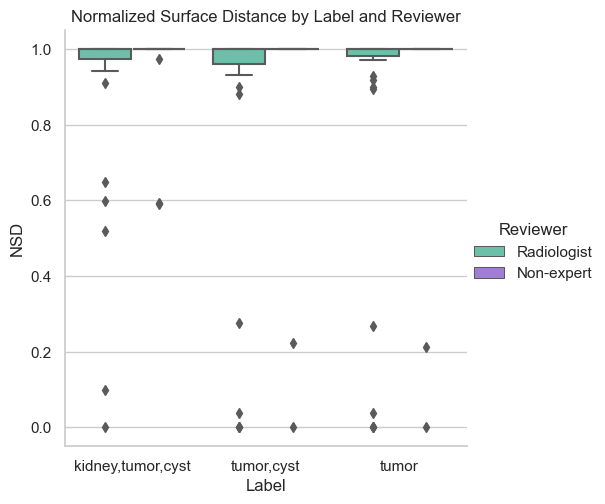

In [14]:
g = sns.catplot(
    data=dsc_df, x="Label", y="NSD", hue="Reviewer", kind="box", palette=revewer_cmap
)
g.set(title="Normalized Surface Distance by Label and Reviewer")

We can compare the segmentation metrics to the reviewers likert scores. This compares dice for all labels against the likert score. These plots show high DSC and NSD scores even for low Likert scores. This could occur for situtations such as Kidney,Tumor,Cyst label scoring very high, but the Tumor label scored low. Resulting in a lower Likert score because the tumor label is more important clinically than the kidney label.

Radiologist: Kendall-τ: 0.91, p-value: 0.00
Non-expert: Kendall-τ: 0.43, p-value: 0.01


[Text(0.5, 20.049999999999997, 'Likert Score'), Text(39.875, 0.5, 'DSC')]

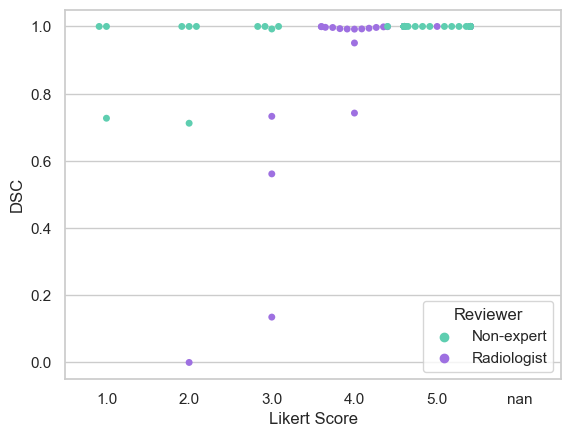

In [15]:
x = (
    dsc_df[dsc_df["Reviewer"] == "Radiologist"]
    .dropna()[["LikertScore", "DSC"]]
    .dropna()
)
rad_tau, rad_p_value = stats.kendalltau(x.LikertScore.values, x.DSC.values)
x = dsc_df[dsc_df["Reviewer"] == "Non-expert"].dropna()[["LikertScore", "DSC"]].dropna()
ne_tau, ne_p_value = stats.kendalltau(x.LikertScore.values, x.DSC.values)
print(
    f"Radiologist: Kendall-\u03c4: {rad_tau:.2f}, p-value: {rad_p_value:.2f}\nNon-expert: Kendall-\u03c4: {ne_tau:.2f}, p-value: {ne_p_value:.2f}"
)

# plot likert score vs dice
g = sns.swarmplot(
    data=dsc_df, x="LikertScore", y="DSC", hue="Reviewer", palette=revewer_cmap
)
g.set(xlabel="Likert Score", ylabel="DSC")

Radiologist: Kendall-τ: 0.91, p-value: 0.00
Non-expert: Kendall-τ: 0.44, p-value: 0.00


[Text(0.5, 20.049999999999997, 'Likert Score'), Text(39.875, 0.5, 'NSD')]

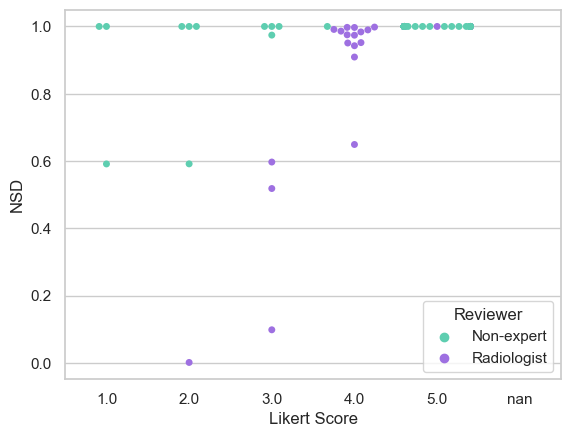

In [16]:
x = (
    dsc_df[dsc_df["Reviewer"] == "Radiologist"]
    .dropna()[["LikertScore", "NSD"]]
    .dropna()
)
rad_tau, rad_p_value = stats.kendalltau(x.LikertScore.values, x.NSD.values)
x = dsc_df[dsc_df["Reviewer"] == "Non-expert"].dropna()[["LikertScore", "NSD"]].dropna()
ne_tau, ne_p_value = stats.kendalltau(x.LikertScore.values, x.NSD.values)
print(
    f"Radiologist: Kendall-\u03c4: {rad_tau:.2f}, p-value: {rad_p_value:.2f}\nNon-expert: Kendall-\u03c4: {ne_tau:.2f}, p-value: {ne_p_value:.2f}"
)

# plot likert score vs nsd
g = sns.swarmplot(
    data=dsc_df, x="LikertScore", y="NSD", hue="Reviewer", palette=revewer_cmap
)
g.set(xlabel="Likert Score", ylabel="NSD")

Since this collection had a variety of contrast phases, we can see the effect of the contrast phase on the Likert scores. We can look at the likert scores for the entire dataset by both the radiologist and non-expert reviewers. As expected the model performs best on scans with in the Nephrogenic and Corticomedullary contrast phases like the training data. There were less scans with excretory phase, but the model performed poorly on these scans. The model also performed poorly on scans with no contrast.

Text(0.5, 0.98, 'Likert Scores by Contrast Phase')

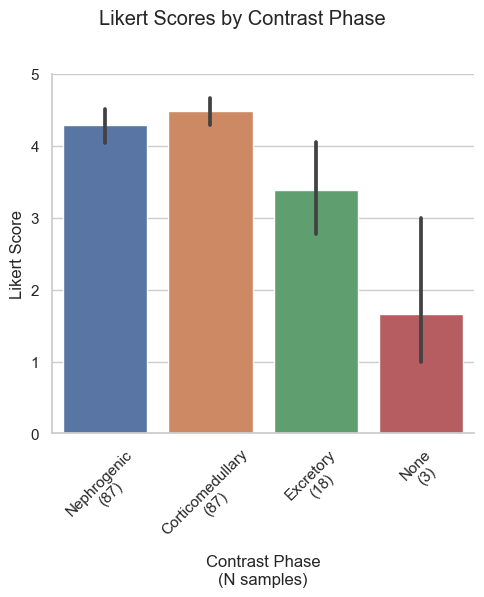

In [17]:
df.replace(
    {
        "Nephrogenic phase / Renal parenchymal phase": "Nephrogenic",
        "Corticomedullary phase / Late arterial phase": "Corticomedullary",
        "Excretory phase": "Excretory",
        "No contrast in scan": "None",
    },
    inplace=True,
)

cnts = dict(df["ContrastPhase"].value_counts())
key = list(cnts.keys())
vals = list(cnts.values())

g = sns.catplot(
    data=df,
    x="ContrastPhase",
    y="LikertScore",
    kind="bar",
    # col="Reviewer",
    order=key,
)
g.set_xticklabels(
    [(key[i] + "\n(" + str(vals[i]) + ")") for i in range(len(key))], rotation=45
)
g.set_axis_labels("Contrast Phase\n(N samples)", "Likert Score")
g.set(ylim=(0, 5))
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Likert Scores by Contrast Phase")

Plot the distribution of lesion and cysts counts in the validation set as measured by the reviewer

In [19]:
rad_df = xdf[xdf["Reviewer"] == "Radiologist"]
rad_df["tumor-pos_cnt"] = (
    rad_df["tumor-true_vol_overlap_cnt"] + rad_df["tumor-false_neg_cnt"]
)
rad_df["cyst-pos_cnt"] = (
    rad_df["cyst-true_vol_overlap_cnt"] + rad_df["cyst-false_neg_cnt"]
)

[Text(0.5, 1.0, 'Tumor Count per Case in Validation Set')]

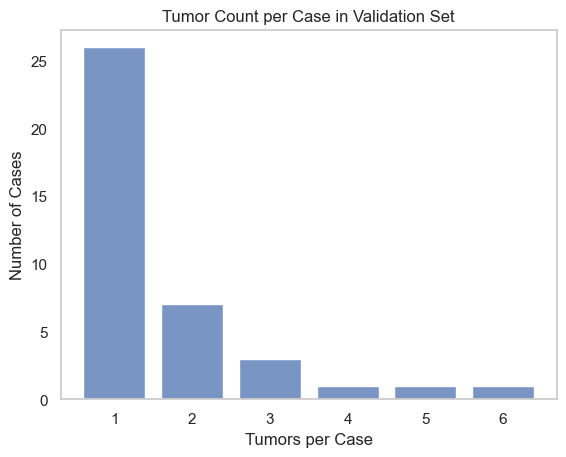

In [20]:
# plot the number of true_vol_overlap_cnt for each row
g = sns.histplot(
    rad_df,
    x="tumor-pos_cnt",
    binwidth=1,
    shrink=0.8,
    palette=vol_cmap,
    discrete=True,
)
g.grid(False)
g.set(xlabel="Tumors per Case")
g.set(ylabel="Number of Cases")
g.set(title="Tumor Count per Case in Validation Set")

[Text(0.5, 1.0, 'Cyst Count per Case in Validation Set')]

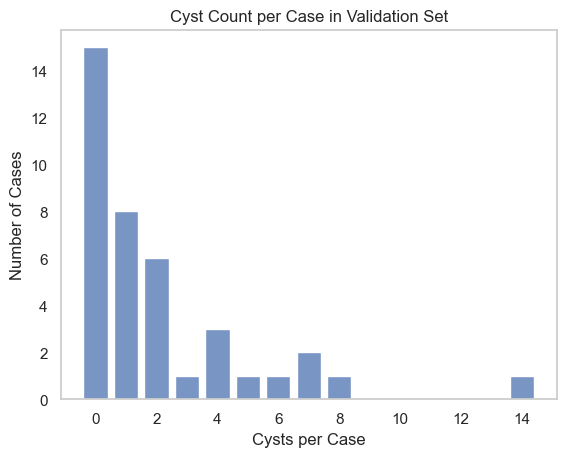

In [21]:
# plot the number of true_vol_overlap_cnt for each row
g = sns.histplot(
    rad_df,
    x="cyst-pos_cnt",
    binwidth=1,
    shrink=0.8,
    palette=vol_cmap,
    discrete=True,
)
g.grid(False)
g.set(xlabel="Cysts per Case")
g.set(ylabel="Number of Cases")
g.set(title="Cyst Count per Case in Validation Set")

We can look at detection rates for kidney tumor and cysts.

In [22]:
TP = rad_df["tumor-true_vol_overlap_cnt"].sum()
FP = rad_df["tumor-false_pos_cnt"].sum()
FN = rad_df["tumor-false_neg_cnt"].sum()
P = rad_df["tumor-pos_cnt"].sum()

Sensitivity = TP / P
MissRate = FN / P
F1 = 2 * TP / (2 * TP + FP + FN)

print("Detection Metrics for Tumors")
print(f"True Positives: {TP}")
print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")
print("")
print(f"Sensitivity: {Sensitivity:.2f}")
print(f"Miss Rate: {MissRate:.2f}")
print(f"F1: {F1:.2f}")

Detection Metrics for Tumors
True Positives: 56.0
False Positives: 3.0
False Negatives: 8.0

Sensitivity: 0.88
Miss Rate: 0.12
F1: 0.91


In [23]:
TP = rad_df["cyst-true_vol_overlap_cnt"].sum()
FP = rad_df["cyst-false_pos_cnt"].sum()
FN = rad_df["cyst-false_neg_cnt"].sum()
P = rad_df["cyst-pos_cnt"].sum()

Sensitivity = TP / P
MissRate = FN / P
F1 = 2 * TP / (2 * TP + FP + FN)

print("Detection Metrics for Cysts")
print(f"True Positives: {TP}")
print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")
print("")
print(f"Sensitivity: {Sensitivity:.2f}")
print(f"Miss Rate: {MissRate:.2f}")
print(f"F1: {F1:.2f}")

Detection Metrics for Cysts
True Positives: 77.0
False Positives: 2.0
False Negatives: 5.0

Sensitivity: 0.94
Miss Rate: 0.06
F1: 0.96
